<a href="https://colab.research.google.com/github/Raidepp/ProjectNom-streamlit/blob/main/ProjectNom_Model_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Nom Model Notebook

In [1]:
# Import all necessary modules
import os, shutil
import datetime
import numpy as np

import tensorflow as tf
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# # Uncomment to utilize GDrive
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Authenticate kaggle accout for downloading datasets
# Dataset source: https://www.kaggle.com/datasets/kmader/food41
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!cp ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d kmader/food41
!unzip food41.zip

Streaming output truncated to the last 5000 lines.
  inflating: images/tacos/1026681.jpg  
  inflating: images/tacos/1030289.jpg  
  inflating: images/tacos/1033196.jpg  
  inflating: images/tacos/1036030.jpg  
  inflating: images/tacos/1042175.jpg  
  inflating: images/tacos/1044043.jpg  
  inflating: images/tacos/1058697.jpg  
  inflating: images/tacos/1059239.jpg  
  inflating: images/tacos/1059326.jpg  
  inflating: images/tacos/1066762.jpg  
  inflating: images/tacos/1070967.jpg  
  inflating: images/tacos/1073468.jpg  
  inflating: images/tacos/1075296.jpg  
  inflating: images/tacos/1085243.jpg  
  inflating: images/tacos/108529.jpg  
  inflating: images/tacos/1086014.jpg  
  inflating: images/tacos/108945.jpg  
  inflating: images/tacos/1089575.jpg  
  inflating: images/tacos/1091159.jpg  
  inflating: images/tacos/1101369.jpg  
  inflating: images/tacos/1109058.jpg  
  inflating: images/tacos/1109744.jpg  
  inflating: images/tacos/1119371.jpg  
  inflating: images/tacos/11237

## Get to Know the Dataset Images

In [7]:
import h5py
import matplotlib.pyplot as plt

DATA_DIR = 'images'

train_h5 = 'food_c101_n10099_r64x64x3.h5'
test_h5 = 'food_test_c101_n1000_r64x64x3.h5'

In [8]:
fl = h5py.File(train_h5, 'r')
# print(fl.keys())

train_img = fl['images']
train_names = fl['category_names']  # 101,
train_cat = fl['category']  # (10099, 101)

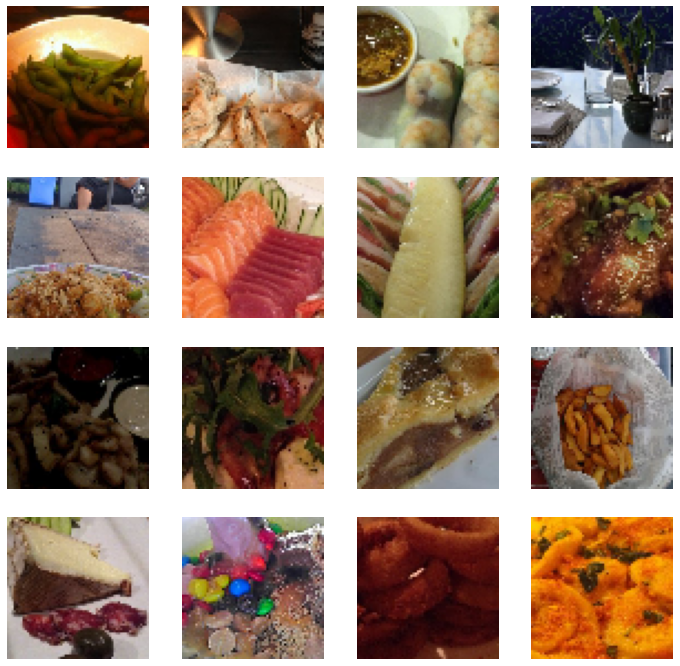

In [9]:
# Plotting some of the images
fig, ax = plt.subplots(4, 4, figsize=(12, 12))
for i in range(16):
    img_arr = train_img[i]
    #plt.subplot(4, 4, 1+i).set_title(train_name[i+1])
    plt.subplot(4, 4, 1+i)
    plt.imshow(img_arr)
    plt.axis('off')

plt.show()

## Creating Dataset using ImageDataGenerator

In [10]:
from shutil import copytree, rmtree

# # Uncomment to only pick a few labels
# def create_subset_func(ls, dest):
#   if os.path.exists(dest):
#     rmtree(dest)
#   os.makedirs(dest)

#   for item in ls:
#     # Copying all images in picked list into new directory
#     copytree( os.path.join('images', item), os.path.join(dest, item) )

# dest = 'subset_images'
# LABELS = ['apple_pie', 'beef_carpaccio', 'bibimbap', 'cup_cakes', 'foie_gras',
#           'french_fries', 'garlic_bread', 'pizza', 'spring_rolls', 'spaghetti_carbonara',
#           'strawberry_shortcake']

# create_subset_func(pick_label, dest)

# Or train with whole labels
with open('./meta/meta/labels.txt') as file:
    lines = file.readlines()
    LABELS = [line.rstrip() for line in lines]

print("Length of labels: ", len(LABELS))    

In [11]:
BATCH_SIZE = 128
IMG_WIDTH, IMG_HEIGHT = 299, 299  # InceptionV3 initially trained on size of 299x299, so we as well use these size

# Creating the ImageDataGenerator
def data_generator_func(data_dir, img_width, img_height, batch_size):
    train_datagen = ImageDataGenerator(rescale=1./255,
                                      rotation_range=60,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=True,
                                      fill_mode='nearest',
                                      validation_split=0.2)
    
    train_generator = train_datagen.flow_from_directory(directory=data_dir,
                                                        target_size=(img_width, img_height),
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        class_mode='categorical',
                                                        subset='training')
    
    val_datagen = ImageDataGenerator(rescale=1./255,
                                    validation_split=0.2)
    
    val_generator = val_datagen.flow_from_directory(directory=data_dir,
                                                    target_size=(img_width, img_height),
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    subset='validation')
    
    return train_generator, val_generator

train_generator, val_generator = data_generator_func('images', IMG_WIDTH, IMG_HEIGHT, BATCH_SIZE)

num_train_generator = train_generator.samples
num_val_generator = val_generator.samples

Length of labels:  101
Found 80800 images belonging to 101 classes.
Found 20200 images belonging to 101 classes.


## Preparing the Pre-Trained Model InceptionV3

In [13]:
# Define the input shape, number of batch, and number of classes
INPUT_SHAPE = (299, 299, 3)
BATCH_SIZE = 128
NUM_CLASSES = 101

icv3 = tf.keras.applications.InceptionV3(input_shape=INPUT_SHAPE, include_top=False)

87924736/87910968 [==============================] - 0s 0us/step


In [ ]:
# Creating the model function
def create_model(base_model, num_classes=NUM_CLASSES):
  # Freezing InceptionV3 layer
  base_model.trainable = False

  x = base_model.output
  x = tf.keras.layers.MaxPooling2D()(x)
  x = tf.keras.layers.Dense(units=512, activation='relu')(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.Flatten()(x)
  outputs = tf.keras.layers.Dense(units=num_classes, kernel_regularizer=tf.keras.regularizers.l2(5e-3), activation='softmax')(x)

  model = tf.keras.Model(inputs=base_model.input, outputs=outputs)

  # Compiling model
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=['accuracy'])
  
  return model

model_icv3 = create_model(icv3)

We using transfer learning to create our model. Trained using InceptionV3, we add a:
1. MaxPooling2D layers, to sharpen the edge detection for our datasets.
2. A Dense layers consist of 512 units and relu activation
3. Dropout layers with rate of 0.2
4. A Flatten layer.
5. An output layers with 101 units. Using L2 kernel regularizer by 5e-3. Softmax activation.

After that, we compile the model with Adam learning rate by 1e-4 and using Categorical Crossentrophy losses. Here is the model architecture:

In [14]:
# # Or load the model if you have the model saved before
# model_icv3 = tf.keras.models.load_model("./drive/MyDrive/Capstone_Related/model_icv3_101class/checkpoint/checkpoint_icv3_29epochs.hdf5", compile=False)

# print("Successfully load the model.")

Successfully load the model.


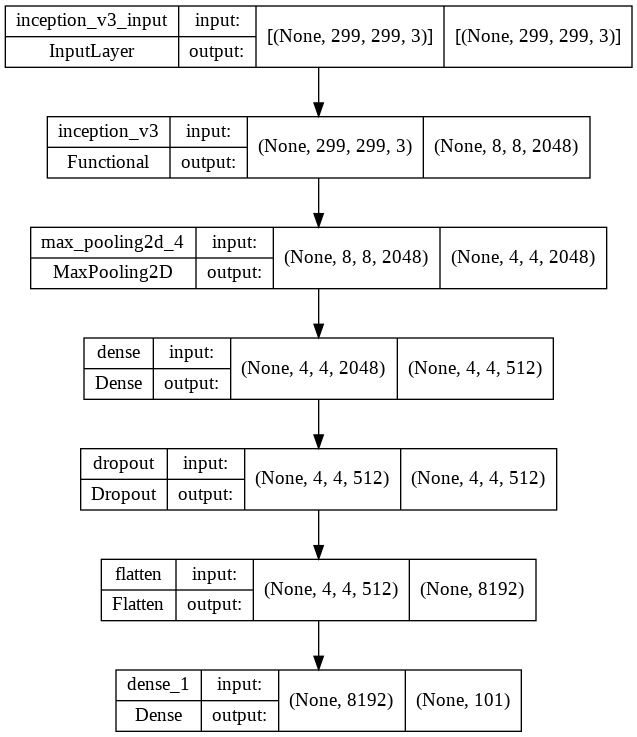

In [15]:
from keras.utils.vis_utils import plot_model

plot_model(model_icv3, to_file='icv3_model_plot.png', show_shapes=True, show_layer_names=True)

## Training the model

In [15]:
# Initializing Tensorboards
import datetime

def tensorboard_callback():
  log_dir = "./drive/MyDrive/Capstone_Related/model_icv3_101class/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")

  return tensorboard_callback

In [16]:
# Creating callbacks for checkpoint and log file
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='./drive/MyDrive/Capstone_Related/model_icv3_101class/checkpoint/checkpoint_icv3_30epochs.hdf5',
                                                          save_best_only=True,
                                                          verbose=1)

csvlogger_callback = tf.keras.callbacks.CSVLogger('./drive/MyDrive/Capstone_Related/model_icv3_101class/csv_log/csvlog_icv3_30epochs.log')

history_icv3 = model_icv3.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    steps_per_epoch=num_train_generator // BATCH_SIZE,
    validation_steps=num_val_generator // BATCH_SIZE,
    callbacks=[csvlogger_callback, checkpoint_callback, tensorboard_callback()],
    verbose=1
)

Saving TensorBoard log files to: ./drive/MyDrive/Capstone_Related/model_icv3_101class/20220610-145157
631/631 [==============================] - ETA: 0s - loss: 1.4992 - accuracy: 0.6486
Epoch 1: val_loss improved from inf to 1.55578, saving model to ./drive/MyDrive/Capstone_Related/model_icv3_101class/checkpoint/checkpoint_icv3_30epochs.hdf5
631/631 [==============================] - 2017s 3s/step - loss: 1.4992 - accuracy: 0.6486 - val_loss: 1.5558 - val_accuracy: 0.6461


### Plotting the model performance

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("./drive/MyDrive/Capstone_Related/model_icv3_101class/csv_log/csvlog_icv3_30epochs.log", sep=",")

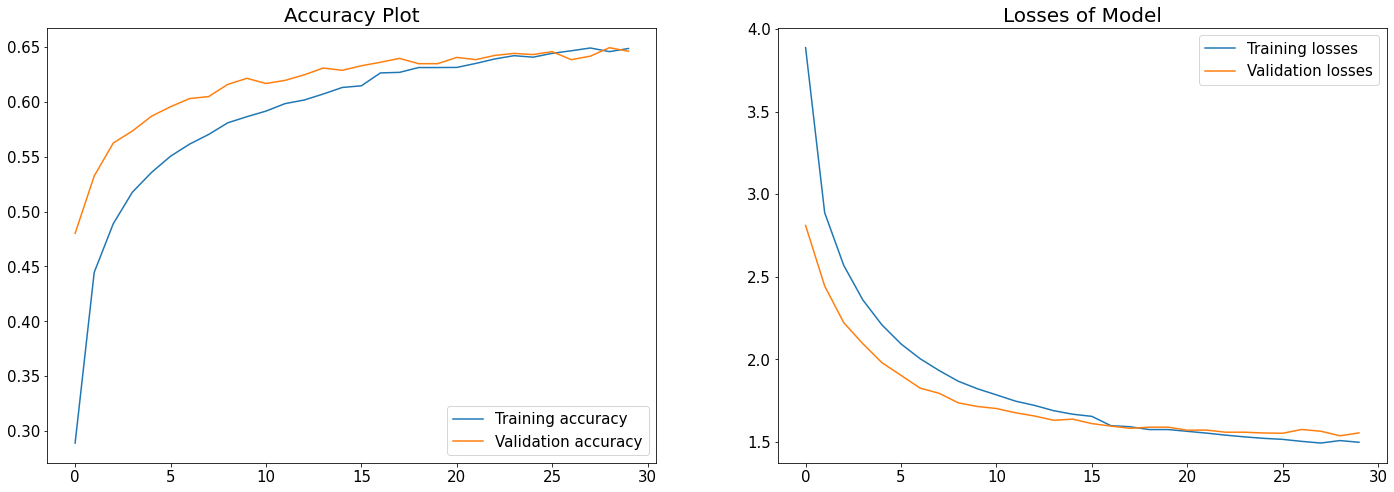

In [19]:
# Use this function if you're using log files from csvlogger callbacks
def plot_history_accuracy():
  #plt.plot(figsize=(40, 50))
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8))
  ax1.plot(df['epoch'], df['accuracy'], label='Training accuracy')
  ax1.plot(df['epoch'], df['val_accuracy'], label='Validation accuracy')
  ax1.set_title("Accuracy Plot", fontdict={'fontsize':20})

  # ax1.set_ylim([0.8, 1])
  ax1.legend(loc=0, prop={'size': 15})
  ax1.tick_params(labelsize=15)

  ax2.plot(df['epoch'], df['loss'], label='Training losses')
  ax2.plot(df['epoch'], df['val_loss'], label='Validation losses')
  ax2.set_title("Losses of Model", fontdict={'fontsize':20})

  # ax2.set_ylim([0.8, 1])
  ax2.legend(loc=0, prop={'size': 15})
  ax2.tick_params(labelsize=15)

  plt.show()

plot_history_accuracy()

## Save the model

In [17]:
# Save to SavedModel Format
tf.saved_model.save(model_icv3, './nom_101class')

# Zip the file and download to your computer
!zip -r ./nom_101class_30epochs.zip ./nom_101class

from google.colab import files
files.download("./nom_101class_30epochs.zip")

INFO:tensorflow:Assets written to: ./nom_101class/assets
  adding: nom_101class/ (stored 0%)
  adding: nom_101class/saved_model.pb (deflated 92%)
  adding: nom_101class/assets/ (stored 0%)
  adding: nom_101class/variables/ (stored 0%)
  adding: nom_101class/variables/variables.index (deflated 79%)
  adding: nom_101class/variables/variables.data-00000-of-00001 (deflated 8%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>